In [3]:
#Импортируем библиотеки
import math as m
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import warnings
warnings.filterwarnings("ignore")

#Задаём функцию для аппроксимации
def mapping(x, a, b): 
    return a*x+b

In [4]:
#Считываем данные файла, задаём режим длины волны и ширины импульса
with open('C:/Users/User/Desktop/Optovolokno/1550SMF-PSCF.txt') as f:
        data = [float(x) for x in (' ').join(f.readlines()).split()]
        data = np.array(data)
km = np.linspace(0,25000,len(data))
lamd = float(input("Выбор режима 1310 или 1550 нм \nДлина волны [нм]: "))
t = float(input("Ширина импульса [нс]:"))
print("\n")
s = len(data)

Выбор режима 1310 или 1550 нм 
Длина волны [нм]: 1550
Ширина импульса [нс]:20




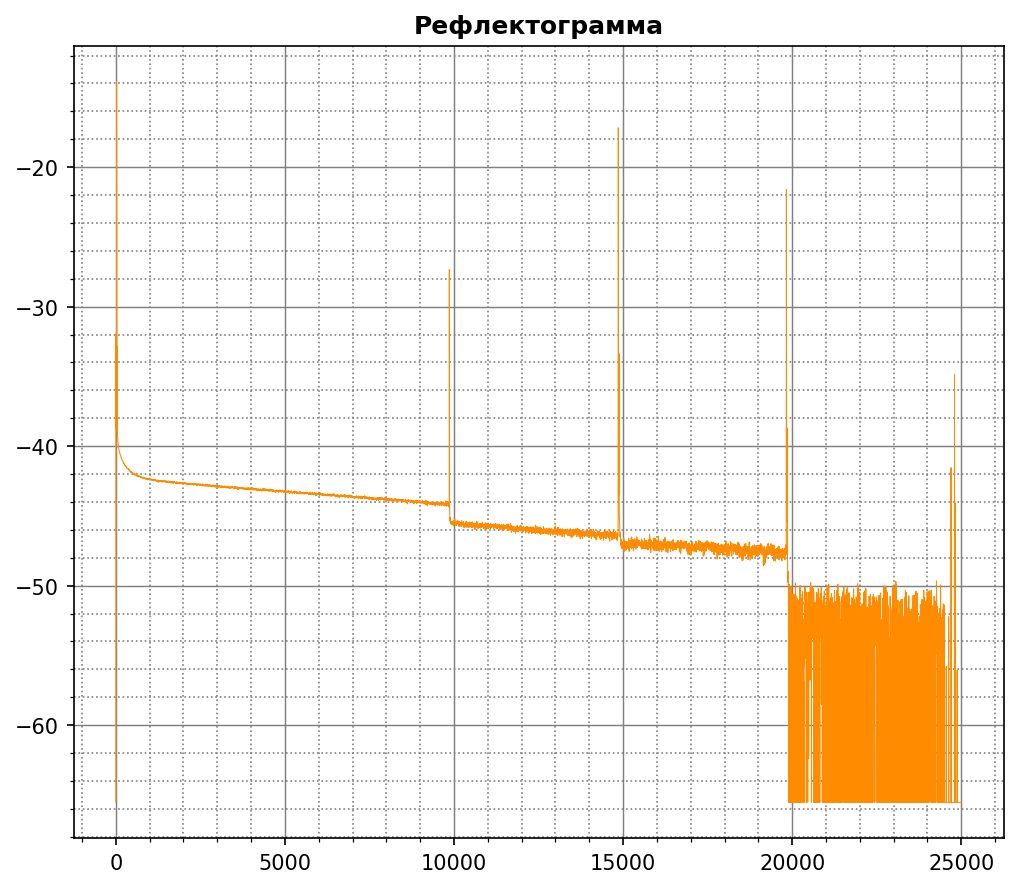

In [5]:
#Построение рефлектограммы
fig, ax = plt.subplots(figsize=(8, 7), dpi=150)
plt.title("Рефлектограмма",color="black", fontweight="bold") # заголовок
plt.xlabel("")
plt.ylabel("")
#plt.xlim([16000, 18000])

plt.minorticks_on()
plt.grid(which='major',
        color = 'grey', 
        linewidth = 0.7)
plt.grid(which='minor', 
        color = 'grey', 
        linestyle = ':')

ax.plot(km, data, "darkorange", linewidth = 0.5)

In [6]:
#Нахождение пиков на рефлектограмме, вычисление среднего значения шумов
d1 = [0]
for i in range(1,s-1):
    d1.append(abs(data[i+1]-data[i]))
d1.append(0)

#d1 = np.array(d1)
d11 = d1[:-50]
d111=[]
for i in range(50):
    if d11[i]!=0:
        d111.append(d11[i])
        
mean_d1 = np.mean(np.array(d111)) #Среднее значение шума после конца линии

ends1=[]

for i in range(1,s-1):
    if d1[i]-d1[i-1]>=mean_d1 and d1[i]-d1[i+1]>=mean_d1:
        ends1.append(i+1)
#Листы начала и конца подозрительных зон - mertv1, mertv2
mertv2 = []
mertv1 = [ends1[0]]
for i in range(0, len(ends1)-1):
    if ends1[i+1]-ends1[i]>=100:
        mertv2.append(ends1[i])
        mertv1.append(ends1[i+1])
    if (sum(ends1, start=i)/len(ends1)-i) - ends1[i]<10:
        break

In [7]:
#Определение конца линии
for i in range(-2, -len(mertv1), -1):
    popt, pcov = optimize.curve_fit(mapping, km[mertv1[i]+50:mertv1[i]+500], data[mertv1[i]+50:mertv1[i]+500])
    a, b = popt
    err = np.sqrt(np.diag(pcov))
    if err[1]>10:
        mertv1 = mertv1[0:i+1]
        k1 = k1[0:i+1]
        mertv2 = mertv2[0:i+1]
        k2 = k2[0:i+1]
        break
          
print("Координата конца линии:", mertv1[-1], "[м]")

Координата конца линии: 19830 [м]


In [8]:
#Проверка "менее заметных" переходов между катушками и обнаружение ложных сигналов для большой ширины импульса (>=1000 нс)
if t>=1000:
    prov = []
    for i in range(0, len(mertv2)):
        popt, pcov = optimize.curve_fit(mapping, km[mertv2[i]+250:mertv1[i+1]-250], data[mertv2[i]+250:mertv1[i+1]-250])
        a, b = popt
        err = np.sqrt(np.diag(pcov))
        popt, pcov = optimize.curve_fit(mapping, km[mertv2[i]+250:mertv2[i]+1250], data[mertv2[i]+250:mertv2[i]+1250])
        a1, b1 = popt
        err1 = np.sqrt(np.diag(pcov))
        popt, pcov = optimize.curve_fit(mapping, km[mertv1[i+1]-1250:mertv1[i+1]-250], data[mertv1[i+1]-1250:mertv1[i+1]-250])
        a2, b2 = popt
        err2 = np.sqrt(np.diag(pcov))
        if abs(a-a1)>0.0002 or abs(a-a2)>0.0002:
            #Одна идентифицированная катушка оказалась двумя
            prov.append([mertv2[i]+250, mertv1[i+1]-250])
    for i in range(len(prov)):
        d100 = d1[prov[i][0]:prov[i][1]]
        max_value = max(d100)
        max_index = d100.index(max_value)
        mertv1.append(max_index + prov[i][0])
        mertv1.sort()
        mertv2.append(max_index + prov[i][0]+50)
    print(mertv1, mertv2)


In [9]:
print("Количество катушек:", len(mertv1)-1)
for i in range(0,len(mertv2)):
    print("Координата начала", i+1, "катушки:", mertv2[i], "[м]")

Количество катушек: 3
Координата начала 1 катушки: 46 [м]
Координата начала 2 катушки: 9859 [м]
Координата начала 3 катушки: 14878 [м]


In [10]:
#Определение типов катушек и погонных затуханий
u = [] #индикатор катушек с "особенностями"

for i in range(0, len(mertv2), 1):
    popt, pcov = optimize.curve_fit(mapping, km[mertv2[i]+250:mertv1[i+1]-250], data[mertv2[i]+250:mertv1[i+1]-250])
    a, b = popt
    err = np.sqrt(np.diag(pcov))
    if lamd==1310:
        if abs((abs(a-err[0])+abs(a+err[0]))/2 - 0.00033) < 0.00002:
            print("Предположительный тип", i+1, "катушки: SMF")
            print("Погонное затухание", i+1, "катушки:", round(-a*1000, 3))
            print("Совпадает с табличным значением:", 100 - round(abs(1+a/0.00033)*100,1), "% \n")
            u.append(1)

        elif abs((abs(a-err[0])+abs(a+err[0]))/2 - 0.0003) < 0.00002:
            print("Предположительный тип", i+1, "катушки: PCSF")
            print("Погонное затухание", i+1, "катушки:", round(-a*1000, 3))
            print("Совпадает с табличным значением:", 100 - round(abs(1+a/0.0003)*100, 1), "% \n")
            u.append(1)
        else:
            print("Тип неопределён. Возможны дополнительные потери за счёт сварки/изгибов.")
            print("Погонное затухание", i+1, "катушки:", round(-a*1000, 3))
            u.append(0)
            
    if lamd==1550:
        if abs((abs(a-err[0])+abs(a+err[0]))/2 - 0.0002) < 0.00002:
            print("Предположительный тип", i+1, "катушки: SMF")
            print("Погонное затухание", i+1, "катушки:", round(-a*1000, 3))
            print("Совпадает с табличным значением:", 100 - round(abs(1+a/0.0002)*100, 1), "% \n")
            u.append(1)

        elif abs((abs(a-err[0])+abs(a+err[0]))/2 - 0.00014) < 0.00002:
            print("Предположительный тип", i+1, "катушки: PCSF")
            print("Погонное затухание", i+1, "катушки:", round(-a*1000, 3))
            print("Совпадает с табличным значением:", 100 - round(abs(1+a/0.00014)*100, 1), "% \n")
            u.append(1)
        else:
            print("Тип неопределён. Возможны дополнительные потери за счёт сварки/изгибов.")
            print("Погонное затухание", i+1, "катушки:", round(-a*1000, 3))
            u.append(0)

Предположительный тип 1 катушки: SMF
Погонное затухание 1 катушки: 0.208
Совпадает с табличным значением: 95.8 % 

Предположительный тип 2 катушки: SMF
Погонное затухание 2 катушки: 0.183
Совпадает с табличным значением: 91.3 % 

Предположительный тип 3 катушки: PCSF
Погонное затухание 3 катушки: 0.145
Совпадает с табличным значением: 96.3 % 



In [11]:
#Вычисление затухания на коннекторах
p1 = []
p2 = []
for i in range(len(mertv2)-1):
    popt, pcov = optimize.curve_fit(mapping, km[mertv2[i]+250:mertv1[i+1]-250], data[mertv2[i]+250:mertv1[i+1]-250])
    a, b = popt
    err = np.sqrt(np.diag(pcov))
    p1.append(a*(mertv2[i]+mertv1[i])+b)
    p2.append(a*(mertv2[i+1]+mertv1[i+1])+b)
    
p = -(np.array(p2)-np.array(p1))

for i in range(len(p)):
    print("Потери на коннекторе между", i+1,"и", i+2, "катушкой:", round(p[i],2), "Дб")

Потери на коннекторе между 1 и 2 катушкой: 4.1 Дб
Потери на коннекторе между 2 и 3 катушкой: 1.83 Дб


In [12]:
#Определение динамического диапазона рефлектометра

dip = max(data[ mertv1[-1]+50:24000])
popt, pcov = optimize.curve_fit(mapping, km[mertv2[0]+250:mertv1[1]-250], data[mertv2[0]+250:mertv1[1]-250])
a, b = popt
err = np.sqrt(np.diag(pcov))
print("Динамический диапазон рефлектометра:", round(abs(b-dip),1))

Динамический диапазон рефлектометра: 6.9
